# Stage 1: Correlation for individual enhancers

In [1]:
import pandas as pd
import numpy as np
import time, re, datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import zscore

from multiprocessing import Pool,cpu_count
num_processors = cpu_count()

print('Starting analysis; %d processors; %s' % (num_processors, datetime.datetime.today()))
t00 =time.time()

# np.random.seed(0)

Starting analysis; 8 processors; 2020-03-13 14:51:46.128420


In [2]:
use_kmers = False
corr_type = 'Spearman';
corr_type = 'Pearson'
features_use = 'mCG'

In [3]:
corr_type

'Pearson'

In [4]:
today=datetime.datetime.today().strftime('%d-%m-%Y')
# fn_load_prefix = 'RegressData/Regress_data_6143genes_19cells_'
# fn_load_prefix = 'RegressData/Regress_data_6174genes_20cells_'
fn_load_prefix = 'RegressData/Regress_data_9811genes_24cells_'

# Load datasets
save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu', 'genes']
# save_vars = ['rnau','genes']
for var in save_vars:
    fn = fn_load_prefix+var+'.pkl'
    cmd = '%s=pd.read_pickle("%s")' % (var, fn)
    exec(cmd)
    print('Loaded %s from %s' % (var, fn))

if use_kmers:
    with np.load(fn_load_prefix+'kmer_countsu.npz', allow_pickle=True) as x:
        kmer_countsu=x['kmer_countsu']
    kmer_countsu = kmer_countsu/kmer_countsu.shape[1]/100
    
    # Testing:
    kmer_countsu = kmer_countsu[:,:2]
    
    print('Kmers shape: ', kmer_countsu.shape)
    Nk=kmer_countsu.shape[1]
    print('Loaded kmers')
else:
    Nk=0
    
# Cell type names
df_cellnames = pd.read_csv('/cndd/Public_Datasets/CEMBA/BICCN_minibrain_data/data_freeze/supp_info/clusters_final/cluster_annotation_scf_round2.tsv',
                       sep='\t', index_col='cluster')

Loaded genes2enhu from RegressData/Regress_data_9811genes_24cells_genes2enhu.pkl
Loaded rnau from RegressData/Regress_data_9811genes_24cells_rnau.pkl
Loaded df_mlevelu from RegressData/Regress_data_9811genes_24cells_df_mlevelu.pkl
Loaded df_atacu from RegressData/Regress_data_9811genes_24cells_df_atacu.pkl
Loaded genes from RegressData/Regress_data_9811genes_24cells_genes.pkl


In [5]:
# ngenes_use = 500000000
# genes = genes.iloc[np.random.permutation(genes.shape[0])[:ngenes_use],:]

In [6]:
genes2enhu = genes2enhu.iloc[[i in genes.index for i in genes2enhu['ensid']],:]
genes2enhu.shape, genes2enhu.index.unique().shape

celltypes = df_mlevelu.columns

In [7]:
if (features_use=='mCG'):
    x = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()
elif (features_use=='ATAC'):
    x = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()
elif (features_use=='mCG_ATAC'):
    x1 = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()
    x2 = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()
    x = f_mcg(x1) * f_atac(x2)
else:
    x = []
    
y = rnau.loc[genes2enhu['ensid'],:].to_numpy()

In [8]:
def my_cc(x,y,ensid,doshuff=False,jshuff=0,corr_type='Pearson',use_abs=True):
    t0=time.time()
    ngenes,ncells = y.shape
    print('Computing correlations for %d gene-enhancer pairs; jshuff=%d; ' % (ngenes,jshuff))
    if doshuff:
        y = y[:,np.random.permutation(ncells)]
#         y = y[np.random.permutation(ngenes),:]

    if (corr_type=='Spearman'):
        y = np.argsort(y,axis=1)
        x = np.argsort(x,axis=1)
    xz = zscore(x, axis=1, nan_policy='omit', ddof=0)
    yz = zscore(y, axis=1, nan_policy='omit', ddof=0)
#     xy_cc = [np.abs(np.corrcoef(x1,y1)[0,1]) for (x1,y1) in zip(x,y)]
    xy_cc = np.nanmean(xz*yz, axis=1)

    xy_cc_df = pd.DataFrame(data=xy_cc, columns=['cc'])
    xy_cc_df['enh_num'] = np.arange(ngenes)
    xy_cc_df['ensid'] = ensid.values
    xy_cc_df['cc_abs'] = np.abs(xy_cc_df['cc'])
    if use_abs:
        xy_cc_df = xy_cc_df.sort_values(['ensid','cc_abs'],ascending=[True,False]).drop_duplicates(['ensid'])
    else:
        xy_cc_df = xy_cc_df.sort_values(['ensid','cc'],ascending=[True,False]).drop_duplicates(['ensid'])
    best_cc    = xy_cc_df['cc']
    best_enh   = xy_cc_df['enh_num']
    best_ensid = xy_cc_df['ensid']
    print('t=%3.3f' % (time.time()-t0))
    
    return best_cc,best_enh,best_ensid,xy_cc

In [9]:
best_cc,best_enh,best_ensid,all_cc = my_cc(x,y,genes2enhu['ensid'],False,0,corr_type)

Computing correlations for 468604 gene-enhancer pairs; jshuff=0; 


/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


t=0.645


In [10]:
nshuff = np.min((num_processors*16,128))
np.random.seed(0)

t0=time.time()
with Pool(processes = num_processors) as p:
    best_cc_shuff_list = p.starmap(my_cc, [(x,y,genes2enhu['ensid'],True,jshuff,corr_type) for jshuff in range(nshuff)])
print('All done, t=%3.3f s' % (time.time()-t0))

Computing correlations for 468604 gene-enhancer pairs; jshuff=0; 
Computing correlations for 468604 gene-enhancer pairs; jshuff=4; 


/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


t=0.805
Computing correlations for 468604 gene-enhancer pairs; jshuff=1; 
Computing correlations for 468604 gene-enhancer pairs; jshuff=8; 
t=0.740
Computing correlations for 468604 gene-enhancer pairs; jshuff=5; 
Computing correlations for 468604 gene-enhancer pairs; jshuff=12; 


/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Computing correlations for 468604 gene-enhancer pairs; jshuff=16; 
t=0.990
Computing correlations for 468604 gene-enhancer pairs; jshuff=2; 
t=0.997
Computing correlations for 468604 gene-enhancer pairs; jshuff=9; 
t=0.888
Computing correlations for 468604 gene-enhancer pairs; jshuff=6; 
t=0.942
Computing correlations for 468604 gene-enhancer pairs; jshuff=13; 
Computing correlations for 468604 gene-enhancer pairs; jshuff=20; 


/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Computing correlations for 468604 gene-enhancer pairs; jshuff=24; 


/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


t=1.416
Computing correlations for 468604 gene-enhancer pairs; jshuff=17; 
t=1.330
Computing correlations for 468604 gene-enhancer pairs; jshuff=10; 
t=1.476
Computing correlations for 468604 gene-enhancer pairs; jshuff=3; 
Computing correlations for 468604 gene-enhancer pairs; jshuff=28; 


/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


t=1.500
Computing correlations for 468604 gene-enhancer pairs; jshuff=7; 
t=1.395
Computing correlations for 468604 gene-enhancer pairs; jshuff=21; 
t=1.503
Computing correlations for 468604 gene-enhancer pairs; jshuff=14; 
t=1.442
Computing correlations for 468604 gene-enhancer pairs; jshuff=25; 


/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


t=1.601
Computing correlations for 468604 gene-enhancer pairs; jshuff=18; 
t=1.598
Computing correlations for 468604 gene-enhancer pairs; jshuff=11; 
t=1.556
t=1.606
Computing correlations for 468604 gene-enhancer pairs; jshuff=29; 
t=1.545
t=1.524
Computing correlations for 468604 gene-enhancer pairs; jshuff=22; 
t=1.519
Computing correlations for 468604 gene-enhancer pairs; jshuff=15; 
Computing correlations for 468604 gene-enhancer pairs; jshuff=32; 
t=1.334
Computing correlations for 468604 gene-enhancer pairs; jshuff=26; 
t=1.438
Computing correlations for 468604 gene-enhancer pairs; jshuff=19; 
t=1.473
Computing correlations for 468604 gene-enhancer pairs; jshuff=36; 
t=1.474
Computing correlations for 468604 gene-enhancer pairs; jshuff=30; 
t=1.413
t=1.556
Computing correlations for 468604 gene-enhancer pairs; jshuff=23; 
t=1.435
Computing correlations for 468604 gene-enhancer pairs; jshuff=40; 
Computing correlations for 468604 gene-enhancer pairs; jshuff=33; 
t=1.530
Computing

In [11]:
alpha = 0.01;
best_cc_shuff = np.hstack([b[0][:,np.newaxis] for b in best_cc_shuff_list])
best_cc_shuff_max = np.percentile(np.abs(best_cc_shuff), 100*(1-alpha), axis=1)
best_cc_shuff_mean = np.abs(best_cc_shuff).mean(axis=1)
sig = np.abs(best_cc).squeeze()>best_cc_shuff_max

# alpha = 0.005;
# sig = best_cc.squeeze()>np.percentile(best_cc_shuff,100*(1-alpha))
fdr = (alpha*len(sig))/np.sum(sig)
print(fdr, np.sum(sig), len(sig), alpha)

0.015647527910685806 6270 9811 0.01


Saved Plots/GenesCorr_mCG_13-03-2020_Pearson


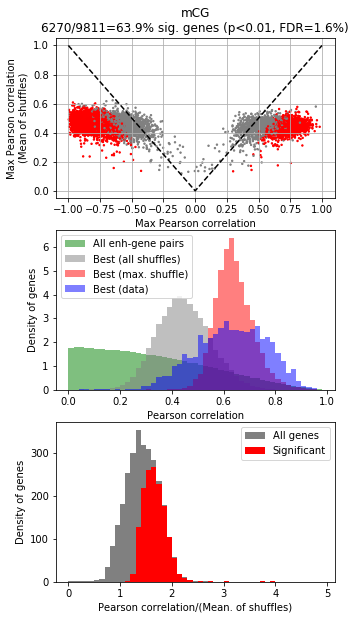

In [12]:
ngenes = best_cc.shape[0]

fig,axs=plt.subplots(3,1,figsize=(5,10))
plt.sca(axs[0])
# sig = best_cc>(best_cc_shuff_mean+3*best_cc_shuff_sd).squeeze()
plt.scatter(best_cc, best_cc_shuff_mean,
            s=2,c=sig,
            cmap = ListedColormap(["gray",'red']))
plt.plot([-1,0,1],[1,0,1],'k--')
plt.grid()
plt.xlabel('Max %s correlation' % corr_type)
plt.ylabel('Max %s correlation\n(Mean of shuffles)' % corr_type)
plt.title('%s\n%d/%d=%3.1f%% sig. genes (p<%3.2g, FDR=%3.1f%%)' % (features_use, 
                                                                 sig.sum(),ngenes,
                                                                 100*sig.sum()/ngenes,
                                                                 alpha, fdr*100))

plt.sca(axs[1])
plt.hist(np.abs(all_cc), bins=np.arange(0,1,0.02),density=True,color='green',label='All enh-gene pairs',alpha=0.5)
plt.hist(best_cc_shuff.reshape(-1,1), bins=np.arange(0,1,0.02),density=True,color='gray',label='Best (all shuffles)',alpha=0.5);
plt.hist(best_cc_shuff_max, bins=np.arange(0,1,0.02),density=True,color='r',label='Best (max. shuffle)',alpha=0.5);
plt.hist(best_cc.squeeze(), bins=np.arange(0,1,0.02),density=True,color='blue',label='Best (data)',alpha=0.5);
# plt.hist(best_cc[sig], bins=np.arange(0,1,0.01),density=True,color='r',label='Significant');
plt.legend()
plt.xlabel(corr_type+' correlation')
plt.ylabel('Density of genes')


plt.sca(axs[2])
plt.hist(best_cc.squeeze()/best_cc_shuff_mean.squeeze(), bins=np.arange(0,5,0.1),density=False,color='gray',
        label='All genes');
plt.hist(best_cc.squeeze()[sig]/best_cc_shuff_mean.squeeze()[sig], bins=np.arange(0,5,0.1),density=False,color='red',
        label='Significant');
# plt.hist(best_cc, bins=np.arange(0,1,0.02),density=True,color='red',label='Data',alpha=0.5);
# plt.hist(best_cc[sig], bins=np.arange(0,1,0.01),density=True,color='r',label='Significant');
plt.xlabel(corr_type+' correlation/(Mean. of shuffles)')
plt.ylabel('Density of genes')
plt.legend()

fn_plot = 'Plots/GenesCorr_%s_%s_%s' % (features_use, today, corr_type)
plt.savefig(fn_plot)
print('Saved %s' % fn_plot)

In [759]:
np.savez('RegressData/GenesCorr_%s_%s.npz' % (features_use, today),
         best_cc=best_cc,best_enh=best_enh,best_ensid=best_ensid,
         sig=sig, best_cc_shuff=best_cc_shuff)
print('Saved data; t=%3.3f; %s' % (time.time()-t00, datetime.datetime.today()))

Saved data; t=67.236; 2020-03-11 10:47:02.608618


In [13]:
all_cc.shape, genes2enhu.shape, best_cc.shape
genes2enhu['cc'] = all_cc
genes2enhu

,gene_chr,gene_start,gene_end,gene_strand,ensid,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss,enh_pos,cc
ensid,,,,,,,,,,,,,,
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108010321,108010428,108146146,108010374.5,135771.5,chr3_108010321_108010428,-0.249313
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108012852,108013721,108146146,108013286.5,132859.5,chr3_108012852_108013721,-0.010517
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108017284,108017576,108146146,108017430.0,128716.0,chr3_108017284_108017576,0.011419
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108018360,108018630,108146146,108018495.0,127651.0,chr3_108018360_108018630,-0.207659
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108019008,108019178,108146146,108019093.0,127053.0,chr3_108019008_108019178,-0.333050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000115704,chr14,73979158,74451303,-,ENSMUSG00000115704,AC154323.2,chr14,74538508,74538783,74451303,74538645.5,-87342.5,chr14_74538508_74538783,-0.003035
ENSMUSG00000115704,chr14,73979158,74451303,-,ENSMUSG00000115704,AC154323.2,chr14,74540432,74540767,74451303,74540599.5,-89296.5,chr14_74540432_74540767,0.459140
ENSMUSG00000115704,chr14,73979158,74451303,-,ENSMUSG00000115704,AC154323.2,chr14,74540802,74540947,74451303,74540874.5,-89571.5,chr14_74540802_74540947,0.509514


In [14]:
best_ensid_inv = pd.Series(best_ensid.index.values, index=best_ensid)
i = best_ensid_inv.loc[genes2enhu.index].values
genes2enhu['best_cc'] = genes2enhu.iloc[i,:]['cc']

i = pd.Series(np.arange(best_ensid.shape[0]), index=best_ensid)
genes2enhu['best_cc_shuff_max'] = best_cc_shuff_max[i.loc[genes2enhu.index]]
isig = sig[best_ensid_inv.loc[genes2enhu.index]].values
genes2enhu['sig'] = (genes2enhu['cc'].abs() >= genes2enhu['best_cc_shuff_max'].abs()) 
genes2enhu['nonsig'] = (genes2enhu['cc'].abs() < genes2enhu['best_cc_shuff_max'].abs())

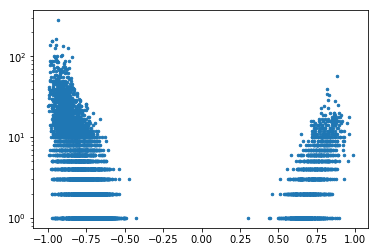

In [15]:
# How many enhancers are 
# best_cc_shuff_max
nsig = genes2enhu.groupby(level=0).sum()[['sig','nonsig']]
nsig['best_cc'] = best_cc.values
plt.semilogy(nsig['best_cc'], nsig['sig'],  '.',
            markersize=5);

In [16]:
nsig['gene_name'] = genes2enhu.loc[nsig.index,:]['gene_name'].drop_duplicates()
nsig.sort_values('sig').iloc[-10:,:]

,sig,nonsig,best_cc,gene_name
ensid,,,,
ENSMUSG00000030102,104.0,95.0,-0.909094,Itpr1
ENSMUSG00000019943,126.0,32.0,-0.950037,Atp2b1
ENSMUSG00000039809,128.0,163.0,-0.870722,Gabbr2
ENSMUSG00000063142,135.0,165.0,-0.901539,Kcnma1
ENSMUSG00000061751,138.0,197.0,-0.946268,Kalrn
ENSMUSG00000052551,138.0,86.0,-0.982806,Adarb2
ENSMUSG00000032503,155.0,35.0,-0.971614,Arpp21
ENSMUSG00000053477,157.0,142.0,-0.973257,Tcf4
ENSMUSG00000022332,164.0,33.0,-0.947037,Khdrbs3


Text(0, 0.5, 'Cumulative fraction of genes')

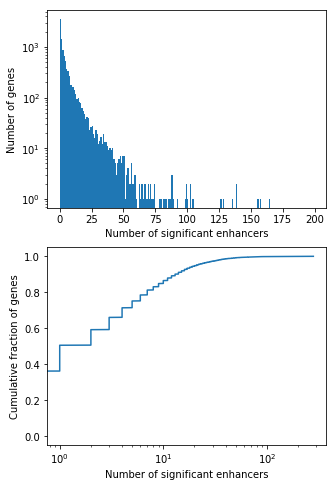

In [17]:
def my_cdfplot(x, label=''):
    plt.semilogx(np.sort(np.abs(x)), np.arange(0,1,1/len(x)), label='%s (%d)\nd=%3.1f±%3.1f kb' %
                 (label, len(x), x.mean()/1000, x.std()/1000/np.sqrt(len(x))))

fig,axs=plt.subplots(2,1,sharex=False,figsize=(5,8))

plt.sca(axs[0])
plt.hist(nsig['sig'].values, bins=np.arange(200),density=False)
plt.xlabel('Number of significant enhancers')
plt.ylabel('Number of genes')
# plt.xscale('log ')
plt.yscale('log')

plt.sca(axs[1])
my_cdfplot(nsig['sig'].values)
plt.xlabel('Number of significant enhancers')
plt.ylabel('Cumulative fraction of genes')

# fn_plot = 'Plots/GenesCorr_NumSigEnh_%s_%s_%s.pdf' % (features_use, today, corr_type)
# plt.savefig(fn_plot)


# Stage 2: Regression modeling across all genes

In [18]:
# Are there any duplicate enhancers?
nenh_sig = genes2enhu.iloc[(best_enh[sig].values),:]['enh_pos'].shape[0]
nenh_sig_unique = genes2enhu.iloc[(best_enh[sig].values),:]['enh_pos'].unique().shape[0]
nenh_sig_genes_unique = genes2enhu.iloc[(best_enh[sig].values),:]['ensid'].unique().shape[0]

In [19]:
mc_u   = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()[best_enh[sig],:]
atac_u = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()[best_enh[sig],:]
genes2enhu_u = genes2enhu.iloc[best_enh[sig],:].copy()
genes2enhu_u = genes2enhu_u.drop('ensid',axis=1).reset_index()

rna_u = rnau.loc[genes2enhu['ensid'],:].to_numpy()
rna_u = rna_u[best_enh[sig],:].copy()

In [20]:
genes2enhu.iloc[(best_enh[sig].values),:]['enh_pos'].shape

(6270,)

In [21]:
cc_mc_rna = np.array([np.corrcoef(x1,y1)[0,1] for (x1,y1) in zip(mc_u,rna_u)])
cc_atac_rna = np.array([np.corrcoef(x1,y1)[0,1] for (x1,y1) in zip(atac_u,rna_u)])

In [22]:
genes2enhu_u.loc[:,'cc_mc_rna'] = cc_mc_rna
genes2enhu_u.loc[:,'cc_atac_rna'] = cc_atac_rna
genes2enhu_u.sort_values('cc_mc_rna')
# genes2enhu_u['cc_atac_rna'] = cc_atac_rna

,ensid,gene_chr,gene_start,gene_end,gene_strand,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss,enh_pos,cc,best_cc,best_cc_shuff_max,sig,nonsig,cc_mc_rna,cc_atac_rna
2062,ENSMUSG00000026890,chr2,36081953,36105408,-,Lhx6,chr2,36085354,36086833,36105408,36086093.5,19314.5,chr2_36085354_36086833,-0.996553,-0.996553,0.706711,True,False,-0.996553,0.411359
6091,ENSMUSG00000096972,chr2,169633646,169888503,-,Gm26883,chr2,169589992,169590269,169888503,169590130.5,298372.5,chr2_169589992_169590269,-0.994687,-0.994687,0.790733,True,False,-0.994687,0.487295
4801,ENSMUSG00000047907,chr2,169633013,170071816,+,Tshz2,chr2,169589992,169590269,169633013,169590130.5,-42882.5,chr2_169589992_169590269,-0.994095,-0.994095,0.772037,True,False,-0.994095,0.485256
4054,ENSMUSG00000039384,chr1,184013302,184075636,+,Dusp10,chr1,184040161,184040753,184013302,184040457.0,27155.0,chr1_184040161_184040753,-0.994009,-0.994009,0.569812,True,False,-0.994009,0.624849
4550,ENSMUSG00000043668,chr8,90247040,90348343,-,Tox3,chr8,90278167,90279549,90348343,90278858.0,69485.0,chr8_90278167_90279549,-0.990720,-0.990720,0.888254,True,False,-0.990720,0.481221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,ENSMUSG00000039759,chr4,151982639,151988997,-,Thap3,chr4,151886989,151887613,151988997,151887301.0,101696.0,chr4_151886989_151887613,0.942261,0.942261,0.589382,True,False,0.942261,-0.373062
723,ENSMUSG00000019803,chr10,42561963,42583632,-,Nr2e1,chr10,42636704,42637217,42583632,42636960.5,-53328.5,chr10_42636704_42637217,0.954779,0.954779,0.727599,True,False,0.954779,0.215514
4686,ENSMUSG00000046138,chr19,29714402,29805989,-,9930021J03Rik,chr19,29661648,29662006,29805989,29661827.0,144162.0,chr19_29661648_29662006,0.956437,0.956437,0.549535,True,False,0.956437,-0.489216
6216,ENSMUSG00000109097,chr7,70178868,70337852,-,Gm29683,chr7,70286702,70287343,70337852,70287022.5,50829.5,chr7_70286702_70287343,0.960141,0.960141,0.799703,True,False,0.960141,0.415195


We found 6270 significant enhancer-gene links, covering 6001 unique enhancers and 6270 unique genes
3864 of these have the expected correlation (negative for mCG, positive for ATAC)
1277 of these have the opposite correlation (positive for mCG, negative for ATAC)


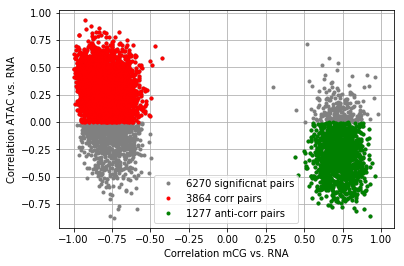

In [23]:
# plt.hist(cc_mc_rna,bins=100,density=True);
# plt.hist(cc_atac_rna,bins=100,density=True);
sig_pos = (genes2enhu_u['cc_mc_rna']<0) & (genes2enhu_u['cc_atac_rna']>0)
sig_neg = (genes2enhu_u['cc_mc_rna']>0) & (genes2enhu_u['cc_atac_rna']<-0)

plt.plot(cc_mc_rna, cc_atac_rna, '.', color='gray', label='%d significnat pairs' % np.sum(sig))
plt.plot(cc_mc_rna[sig_pos], cc_atac_rna[sig_pos], 'r.', label='%d corr pairs' % np.sum(sig_pos))
plt.plot(cc_mc_rna[sig_neg], cc_atac_rna[sig_neg], 'g.', label='%d anti-corr pairs' % np.sum(sig_neg))
# plt.plot(cc_mc_rna[[gshow_pos]], cc_atac_rna[[gshow_pos]], 'g.')
plt.xlabel('Correlation mCG vs. RNA')
plt.ylabel('Correlation ATAC vs. RNA')
plt.grid()
plt.legend()

print('We found %d significant enhancer-gene links, covering %d unique enhancers and %d unique genes' %
     (nenh_sig, nenh_sig_unique, nenh_sig_genes_unique))
print('%d of these have the expected correlation (negative for mCG, positive for ATAC)' %
     (np.sum(sig_pos)))
print('%d of these have the opposite correlation (positive for mCG, negative for ATAC)' %
     (np.sum(sig_neg)))
plt.savefig('Plots/EnhancerRegression_SigEnhancers_scatter_mCG_ATAC_corr_%dGenes_%dCelltypes_%s' % 
           (genes2enhu.ensid.unique().shape[0], len(celltypes), today))

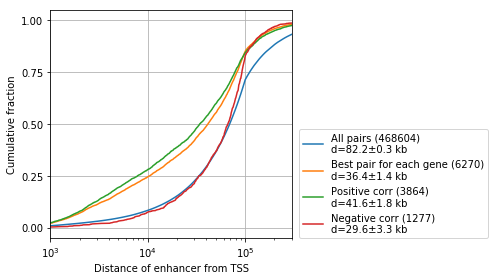

In [24]:
def my_cdfplot(x, label=''):
    plt.semilogx(np.sort(np.abs(x)), np.arange(0,1,1/len(x)), label='%s (%d)\nd=%3.1f±%3.1f kb' %
                 (label, len(x), x.mean()/1000, x.std()/1000/np.sqrt(len(x))))

plt.figure(figsize=(7,4))
my_cdfplot(genes2enhu['dtss'], label='All pairs')
my_cdfplot(genes2enhu_u['dtss'], label='Best pair for each gene')
my_cdfplot(genes2enhu_u['dtss'][sig_pos], label='Positive corr')
my_cdfplot(genes2enhu_u['dtss'][sig_neg], label='Negative corr')
plt.legend(bbox_to_anchor=(1.01, 0.5))
plt.grid()
plt.xlim([1e3,3e5])
plt.xlabel('Distance of enhancer from TSS')
plt.ylabel('Cumulative fraction')
plt.yticks(ticks=[0,.25,.5,.75,1]);
plt.tight_layout()
plt.savefig('Plots/EnhancerRegression_SigEnhancers_dTSS_cdf_%dGenes_%dCelltypes_%s' % 
           (genes2enhu.ensid.unique().shape[0], len(celltypes), today))

In [25]:
sig.shape, mc_u.shape

((9811,), (6270, 24))

In [26]:
# Ordinary linear regression with CV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, make_scorer
from sklearn.preprocessing import PolynomialFeatures

mdl = LinearRegression(fit_intercept=True, normalize=True)
X = np.concatenate((mc_u,atac_u),axis=1).copy()
y = np.log10(rna_u+1).copy()

X = zscore(X, axis=0)
y = zscore(y, axis=0)
y = y - np.mean(y,axis=1,keepdims=True)

# X = X[sig_pos,:]
# y = y[sig_pos,:]

ngenes,ncells = y.shape
print('%d genes, %d celltypes' % (ngenes,ncells))

intxn_order = 4

my_r2 = make_scorer(r2_score)
res_cv = {}
cv = 5
for i,yi in enumerate(y.T):
    # Regression using only mCG and ATAC from the same cell type
    Xu = X[:,[i,i+ncells]]
    Xu = np.concatenate((X[:,[i,i+ncells]],
#                      np.mean(X[:,:ncells],axis=1,keepdims=True),
#                      np.mean(X[:,ncells:],axis=1,keepdims=True),
                    ),axis=1)
#     Xu = PolynomialFeatures(degree=3, include_bias=False).fit_transform(Xu)

    res_cvi = cross_validate(mdl,Xu,yi,cv=cv,
                            scoring=my_r2,
                            return_train_score=True,
                            verbose=0)
    if i==0:
        print('Simple model: %d parameters' % Xu.shape[1])
        dof_simple=Xu.shape[1]
    for m in res_cvi:
        if (m in res_cv):
            res_cv[m] = np.vstack((res_cv[m], res_cvi[m]))
        else:
            res_cv[m]=res_cvi[m]
            
    # Regression using mCG and ATAC from the same cell type, as well as the mean across all cell types

#     res_cvi = cross_validate(mdl,X,yi,cv=cv,
#                             scoring=my_r2,
#                             return_train_score=True,
#                             verbose=0)
    Xu = np.concatenate((X[:,[i,i+ncells]],
                         np.mean(X[:,:ncells],axis=1,keepdims=True),
                         np.mean(X[:,ncells:],axis=1,keepdims=True),
                        ),axis=1)
    Xu = PolynomialFeatures(degree=intxn_order, include_bias=False).fit_transform(Xu)

    res_cvi = cross_validate(mdl, Xu, yi,
                            cv=cv,
                            scoring=my_r2,
                            return_train_score=True,
                            verbose=0)
    if i==0:
        print('Complex model: %d parameters' % Xu.shape[1])
        dof_complex=Xu.shape[1]

    for m1 in res_cvi:
        m = m1+'_all'
        if (m in res_cv):
            res_cv[m] = np.vstack((res_cv[m], res_cvi[m1]))
        else:
            res_cv[m]=res_cvi[m1]


6270 genes, 24 celltypes
Simple model: 2 parameters
Complex model: 69 parameters


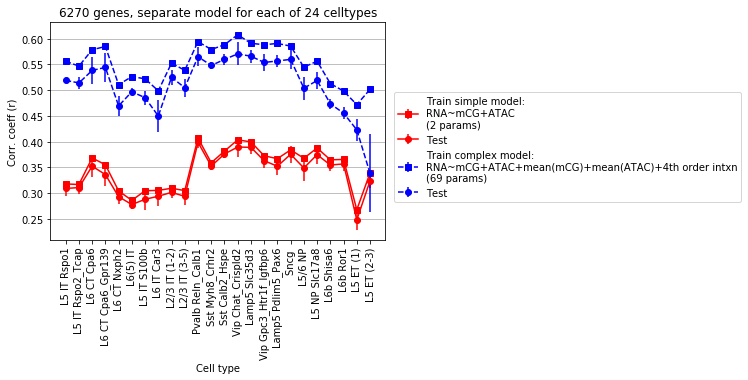

In [27]:
cellnames = df_cellnames.loc[celltypes]['annot']

# Show the OLS results
def myplot(x, label='', fmt=''):
    x[x<0] = 0
    xu = np.sqrt(x)
    plt.errorbar(cellnames, xu.mean(axis=1), xu.std(axis=1)/np.sqrt(cv),
            label=label, fmt=fmt)

myplot(res_cv['train_score'],fmt='rs-', label='Train simple model:\nRNA~mCG+ATAC\n(%d params)' % dof_simple)
myplot(res_cv['test_score'],fmt='ro-', label='Test')
myplot(res_cv['train_score_all'],fmt='bs--', label='Train complex model:\nRNA~mCG+ATAC+mean(mCG)+mean(ATAC)+%dth order intxn\n(%d params)' % 
          (intxn_order, dof_complex))
myplot(res_cv['test_score_all'],fmt='bo--', label='Test')
plt.legend(bbox_to_anchor=(1.01, 0.7))
plt.xlabel('Cell type')
plt.ylabel('Score (R^2)')
plt.xticks(rotation=90);
plt.grid(axis='y')
plt.title('%d genes, separate model for each of %d celltypes' % y.shape)
plt.savefig('Plots/EnhancerRegression_SigEnhancers_OLS_%dGenes_%dCelltypes_%s' % 
           (genes2enhu.ensid.unique().shape[0], len(celltypes), today))

In [28]:
# # Multi-task LASSO regression with CV
# from sklearn.linear_model import MultiTaskLassoCV

# t0=time.time()
# mdl = MultiTaskLassoCV(fit_intercept=True, normalize=True, cv=cv, 
#                        selection='random',
#                        random_state=0)

# X = np.concatenate((mc_u,atac_u),axis=1).copy()
# y = np.log10(rna_u+1).copy()

# X = zscore(X[sig_pos,:], axis=0)
# y = zscore(np.log10(y[sig_pos,:]+1), axis=0)

# reg = mdl.fit(X,y)
# print('Done fitting LASSO, t=%3.3f s' % (time.time()-t0))

In [29]:
# plt.errorbar(reg.alphas_, reg.mse_path_.mean(axis=1), reg.mse_path_.std(axis=1))
# plt.vlines(reg.alpha_, plt.ylim()[0], plt.ylim()[1], 'k')
# plt.xscale('log')

In [30]:
# Single task LASSO with CV, interaction terms
from sklearn.linear_model import LassoCV

Xu_all = []
for i,yi in enumerate(y.T):
    Xu = np.concatenate((X[:,[i,i+ncells]],
                         np.mean(X[:,:ncells],axis=1,keepdims=True),
                         np.mean(X[:,ncells:],axis=1,keepdims=True),
                        ),axis=1)
    Xu_all.append(Xu.T)

Xu_all = np.dstack(Xu_all).reshape(4,-1).T
Xu_fit = PolynomialFeatures(degree=intxn_order, include_bias=False).fit(Xu_all)
feature_names = Xu_fit.get_feature_names(input_features=['mC','A','mCm','Am'])
Xu_all = PolynomialFeatures(degree=intxn_order, include_bias=False).fit_transform(Xu_all)

In [31]:
print(Xu_all.shape, y.shape)
yu = y.ravel()
print(Xu_all.shape, yu.shape)

t0=time.time()
mdl = LassoCV(fit_intercept=True, normalize=True, cv=cv, 
              selection='random',
              random_state=0,
              n_jobs=8)
reg = mdl.fit(Xu_all,yu)
print('Done fitting LASSO, t=%3.3f s' % (time.time()-t0))

(150480, 69) (6270, 24)
(150480, 69) (150480,)
Done fitting LASSO, t=6.269 s


Text(0, 0.5, 'R-squared')

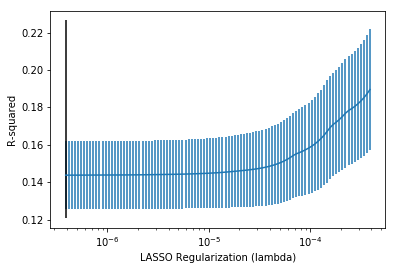

In [32]:
plt.errorbar(reg.alphas_, reg.mse_path_.mean(axis=1), reg.mse_path_.std(axis=1))
plt.vlines(reg.alpha_, plt.ylim()[0], plt.ylim()[1], 'k')
plt.xscale('log')
plt.xlabel('LASSO Regularization (lambda)')
plt.ylabel('R-squared')

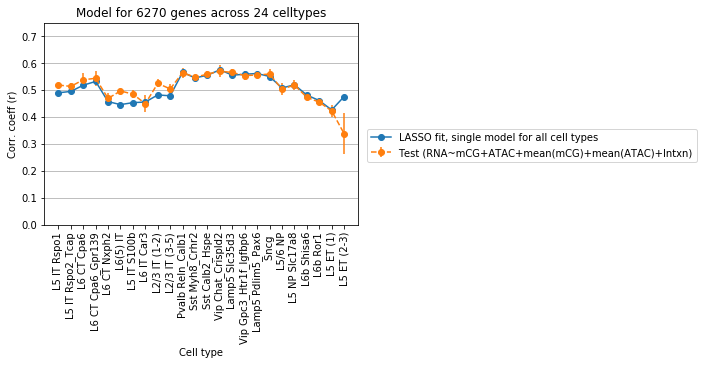

In [33]:
yhat = reg.predict(Xu_all).reshape(y.shape)
cc = [np.corrcoef(y1,y1hat)[0,1] for (y1,y1hat) in zip(y.T,yhat.T)]

plt.figure(figsize=(10,5))
plt.plot(cellnames, cc, 'o-', label='LASSO fit, single model for all cell types')
myplot(res_cv['test_score_all'], label='Test (RNA~mCG+ATAC+mean(mCG)+mean(ATAC)+Intxn)', fmt='o--')
plt.legend(bbox_to_anchor=(1.01, 0.5))

plt.xlabel('Cell type')
plt.ylabel('Corr. coeff (r)')
plt.xticks(rotation=90);
plt.grid(axis='y')
plt.tight_layout()
plt.ylim([0,.75])
plt.savefig('Plots/EnhancerRegression_SigEnhancers_CompareLASSO_%dGenes_%dCelltypes_%s' % 
           (genes2enhu.ensid.unique().shape[0], len(celltypes), today))
plt.title('Model for %d genes across %d celltypes' % y.shape)
plt.savefig('Plots/EnhancerRegression_SigEnhancers_LASSO_CorrCoef_%dGenes_%dCelltypes_%s' % 
           (genes2enhu.ensid.unique().shape[0], len(celltypes), today))

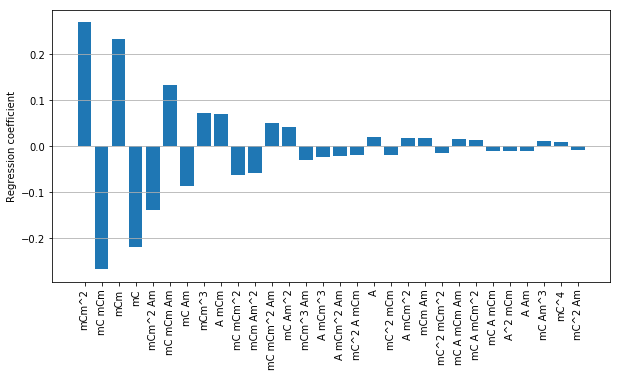

In [34]:
plt.figure(figsize=(10,5))
show = np.abs(reg.coef_)>0.01
show = np.argsort(np.abs(reg.coef_))[-30:][::-1]
plt.bar(np.array(feature_names)[show], reg.coef_[show])
plt.xticks(rotation=90);
plt.ylabel('Regression coefficient')
plt.grid(axis='y')
plt.savefig('Plots/EnhancerRegression_SigEnhancers_LASSO_Coefficients_%dGenes_%dCelltypes_%s' % 
           (genes2enhu.ensid.unique().shape[0], len(celltypes), today))

# Apply the nonlinear model to all enhancer

In [38]:
mc_u   = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()

atac_u = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()
genes2enhu_u = genes2enhu.copy()
genes2enhu_u = genes2enhu_u.drop('ensid',axis=1).reset_index()

rna_u = rnau.loc[genes2enhu['ensid'],:].to_numpy()

rna_u.shape, mc_u.shape, atac_u.shape

((468604, 24), (468604, 24), (468604, 24))

In [39]:
X = np.concatenate((mc_u,atac_u),axis=1).copy()
y = np.log10(rna_u+1).copy()

X = zscore(X, axis=0)
y = zscore(y, axis=0)
y = y - np.mean(y,axis=1,keepdims=True)

X.shape, y.shape

((468604, 48), (468604, 24))

In [40]:
Xu_all = []
for i,yi in enumerate(y.T):
    Xu = np.concatenate((X[:,[i,i+ncells]],
                         np.mean(X[:,:ncells],axis=1,keepdims=True),
                         np.mean(X[:,ncells:],axis=1,keepdims=True),
                        ),axis=1)
    Xu_all.append(Xu.T)

Xu_all = np.dstack(Xu_all).reshape(4,-1).T
Xu_fit = PolynomialFeatures(degree=intxn_order, include_bias=False).fit(Xu_all)
feature_names = Xu_fit.get_feature_names(input_features=['mC','A','mCm','Am'])
Xu_all = PolynomialFeatures(degree=intxn_order, include_bias=False).fit_transform(Xu_all)
Xu_all.shape, y.shape

((11246496, 69), (468604, 24))

In [41]:
yhat = reg.predict(Xu_all).reshape(y.shape)

In [42]:
x = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()
best_cc,best_enh,best_ensid,all_cc = my_cc(-x,y,genes2enhu['ensid'],False,0,corr_type)

Computing correlations for 468604 gene-enhancer pairs; jshuff=0; 


/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


t=0.587


In [58]:
best_cc2,best_enh2,best_ensid2,all_cc2 = my_cc(yhat,y,genes2enhu['ensid'],False,0,corr_type)

Computing correlations for 468604 gene-enhancer pairs; jshuff=0; 
t=0.708


(468604, 24)

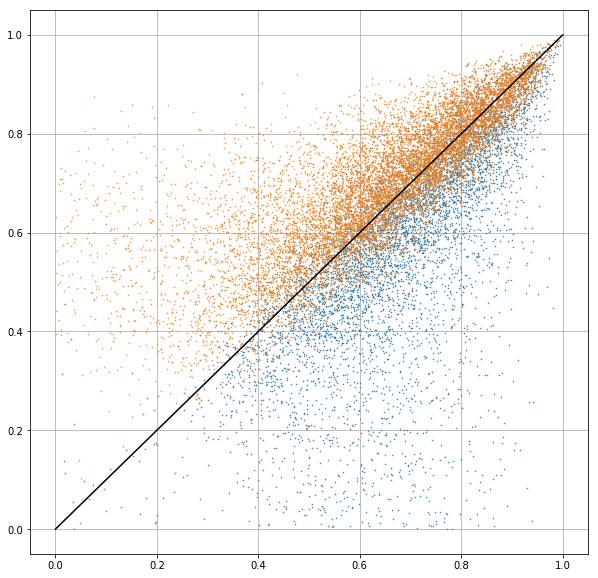

In [44]:
plt.figure(figsize=(10,10))
# plt.scatter(all_cc[::10], all_cc2[::10], s=0.1)
plt.plot(np.abs(all_cc[best_enh]), np.abs(all_cc2[best_enh]), '.', markersize=1)
plt.plot(np.abs(all_cc[best_enh2]), np.abs(all_cc2[best_enh2]), '.', markersize=1)
plt.plot([0,1],[0,1],'k')
plt.grid()

1.021974429930335


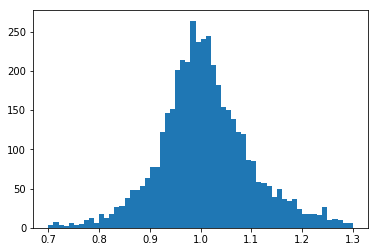

In [45]:
plt.hist(np.abs(best_cc2)/np.abs(best_cc), bins=np.arange(0.7,1.3,0.01));
print((np.abs(best_cc2)/np.abs(best_cc)).mean())

In [46]:
# For each gene, find all enhancers with significant cc
df = pd.DataFrame(data=all_cc, columns=['cc'], index=genes2enhu[['ensid','enh_pos']])
df['ensid'] = genes2enhu['ensid'].values
df['enh_pos'] = genes2enhu['enh_pos'].values
df['cc2'] = all_cc2

In [47]:
df['good_pairs'] = df['cc']>0.6
df['good_pairs2'] = df['cc2']>0.6

npairs_df=df.groupby('ensid')[['good_pairs','good_pairs2']].sum()

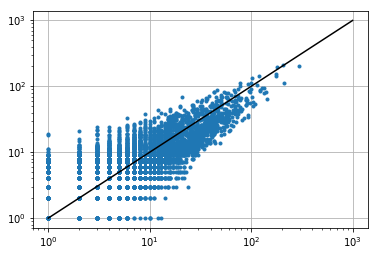

In [48]:
plt.loglog(npairs_df['good_pairs']+1,npairs_df['good_pairs2']+1,'.')
plt.plot([1,1e3],[1,1e3],'k')
plt.grid()

In [49]:
np.mean((npairs_df['good_pairs2']+1)/(npairs_df['good_pairs']+1))

1.3453375262951408

# Average over all the enhancers linked to a single gene

In [124]:
df_mlevelu

,1-1,1-2,2-1,2-2,2-3,3-1,3-2,3-3,4-1,4-2,...,6-2,6-3,6-4,6-5,7-1,7-2,8-1,8-2,9-1,9-2
enh_pos,,,,,,,,,,,,,,,,,,,,,
chr10_100009732_100010967,0.419738,0.542024,0.637262,0.664619,0.540416,0.676953,0.643587,0.484375,0.556355,0.484056,...,0.141818,0.471429,0.204225,0.495146,0.589633,0.573604,0.570000,0.841727,0.491667,0.606061
chr10_100013831_100014068,0.685185,0.166667,0.437500,0.699115,0.819277,0.370370,0.405063,0.737965,0.346535,0.353933,...,0.800000,0.967742,0.880000,1.000000,0.980769,0.958333,0.818182,0.960000,1.000000,0.833333
chr10_100016960_100018009,0.076299,0.156977,0.129489,0.082168,0.426304,0.360158,0.317073,0.114286,0.045677,0.013962,...,0.078571,0.523810,0.162791,0.458333,0.450311,0.465608,0.127273,0.037313,0.306931,0.315068
chr10_100018530_100019593,0.135922,0.038023,0.056159,0.063333,0.134948,0.130901,0.079114,0.035714,0.057143,0.011799,...,0.125490,0.734043,0.109375,0.637168,0.395349,0.354839,0.111111,0.088235,0.017544,0.054545
chr10_100019604_100019864,0.055000,0.053691,0.041575,0.058091,0.099585,0.028871,0.049383,0.058824,0.048780,0.016055,...,0.358974,0.878788,0.446602,0.859649,0.393162,0.493151,0.107143,0.105263,0.000000,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_99853186_99853303,0.342857,0.350000,0.467742,0.731707,0.640000,0.316667,0.372093,0.501584,0.603774,0.504587,...,0.250000,0.125000,0.400000,0.562500,0.545455,0.555556,0.501584,0.846154,0.501584,0.501584
chrX_9997194_9997721,0.821429,0.562500,0.514851,0.784314,0.506494,0.546218,0.400000,0.454545,0.946809,0.959064,...,0.974684,1.000000,0.914894,0.954545,0.962264,1.000000,1.000000,0.933333,0.791730,0.346154
chrX_99974800_99975115,0.053333,0.023622,0.000000,0.000000,0.051020,0.006944,0.022727,0.061843,0.061728,0.019608,...,0.000000,0.000000,0.000000,0.166667,0.088235,0.230769,0.000000,0.200000,0.000000,0.000000


In [135]:
def myz(x):
    z = zscore(x, axis=1, nan_policy='omit', ddof=0)
    return z
def make_df(z):
    z_df = pd.DataFrame(data=z, columns=df_mlevelu.columns, index=rnau.index)
    return z_df

multiEnh = {}
multiEnh['rna'] = myz(rnau.values);
multiEnh['rna_hat_1Enh'] = myz(yhat[best_enh2,:])
multiEnh['rna_hat_AllEnh'] = myz(yhat[best_enh2,:])
multiEnh['rna_hat_AllSigEnh'] = np.zeros(yhat[best_enh2,:].shape)+np.nan;
t0=time.time()
for i,c in enumerate(celltypes):
    df = pd.DataFrame(data=yhat[:,i], columns=['yhat'])
    df['ensid'] = genes2enhu.loc[:,'ensid'].values
    multiEnh['rna_hat_AllEnh'][:,i] = df.groupby('ensid')['yhat'].mean()
    df = df.loc[genes2enhu.sig.values,:]
    multiEnh['rna_hat_AllSigEnh'][sig,i] = df.groupby('ensid')['yhat'].mean()
    
multiEnh['rna'] = make_df(multiEnh['rna']);
multiEnh['rna_hat_1Enh'] = make_df(multiEnh['rna_hat_1Enh']);
multiEnh['rna_hat_AllEnh'] = make_df(multiEnh['rna_hat_AllEnh'])
multiEnh['rna_hat_AllSigEnh'] = make_df(multiEnh['rna_hat_AllSigEnh'])
print(time.time()-t0)

1.0508649349212646


Text(0, 0.5, 'Correlation across genes')

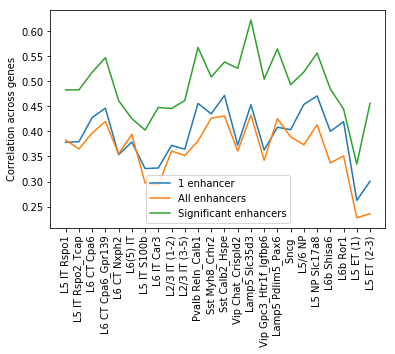

In [136]:
cc_1Enh = np.diag(np.corrcoef(multiEnh['rna'].values, multiEnh['rna_hat_1Enh'].values, rowvar=False)[:ncells,ncells:])
cc_AllEnh = np.diag(np.corrcoef(multiEnh['rna'].values, multiEnh['rna_hat_AllEnh'].values, rowvar=False)[:ncells,ncells:])
cc_AllSigEnh = np.diag(np.corrcoef(multiEnh['rna'].values[sig,:], multiEnh['rna_hat_AllSigEnh'].values[sig,:], rowvar=False)[:ncells,ncells:])

plt.plot(cellnames, cc_1Enh, label='1 enhancer')
plt.plot(cellnames, cc_AllEnh, label='All enhancers')
plt.plot(cellnames, cc_AllSigEnh, label='Significant enhancers')
plt.legend()
plt.xticks(rotation=90);
plt.ylabel('Correlation across genes')

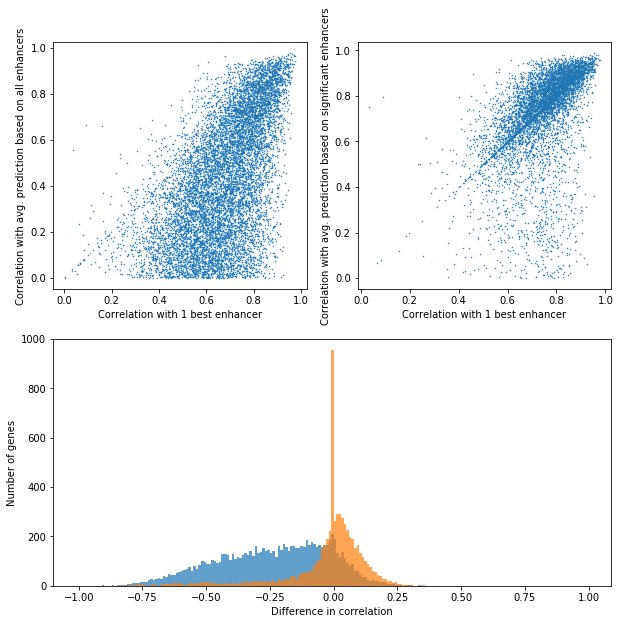

In [166]:
def cc_gene(x,y):
    c = [np.corrcoef(x1,y1)[0,1] for (x1,y1) in zip(x,y)]
    return c

cc_1Enh = cc_gene(multiEnh['rna'].values, multiEnh['rna_hat_1Enh'].values)
cc_AllEnh = cc_gene(multiEnh['rna'].values, multiEnh['rna_hat_AllEnh'].values)
cc_AllSigEnh = cc_gene(multiEnh['rna'].values, multiEnh['rna_hat_AllSigEnh'].values)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(np.abs(cc_1Enh), np.abs(cc_AllEnh), '.', markersize=1)
plt.xlabel('Correlation with 1 best enhancer')
plt.ylabel('Correlation with avg. prediction based on all enhancers')

plt.subplot(2,2,2)
plt.plot(np.abs(cc_1Enh), np.abs(cc_AllSigEnh), '.', markersize=1)
plt.xlabel('Correlation with 1 best enhancer')
plt.ylabel('Correlation with avg. prediction based on significant enhancers')

plt.subplot(2,1,2)
plt.hist(np.abs(cc_AllEnh)-np.abs(cc_1Enh), bins=np.arange(-1,1,1/100), alpha=0.7, label='All enhancers-Best enhancer')
plt.hist(np.abs(cc_AllSigEnh)-np.abs(cc_1Enh), bins=np.arange(-1,1,1/100), alpha=0.7, label='Sig enhancers-Best enhancer');
plt.xlabel('Difference in correlation')
plt.ylabel('Number of genes')

plt.savefig('Plots/EnhancerRegression_Correlation_1Enh_vs_AllEnh_%dGenes_%dCelltypes_%s' % 
           (genes2enhu.ensid.unique().shape[0], len(celltypes), today))

# Nonlinear model fitting

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [124]:
X = np.concatenate((mc_u,atac_u),axis=1).copy()
y = np.log10(rna_u+1).copy()
ngenes,ncells = y.shape

X.shape, y.shape

((6270, 48), (6270, 24))

In [125]:
# Define a class for the NN architecture
Ngenes, Nc = y.shape
Nx = X.shape[1]
N1 = 128
N2 = 32
N3 = 0

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(Nx, N1);
        self.fc2 = nn.Linear(N1, N2);
#         self.fc3 = nn.Linear(N2, N3);
        self.fc4 = nn.Linear(N2, Nc);
        
    def forward(self, x):

        x = F.relu(self.fc1(x))       # Out: N x N1
        x = F.relu(self.fc2(x))       # Out: N x N2
#         x = F.relu(self.fc3(x))       # Out: N x N3
        x = self.fc4(x)               # Out: N x C
        
        return x

In [126]:
# Initialize
def myinit():
    global net, optimizer, criterion, scheduler, loss_test, loss_train, test, train, ensids
    net = Net()
    net.to(device)

#     # Initialize the kmer weights to 0 and turn off learning
#     net.fc1_kmers.requires_grad_(False)
#     net.fc1_kmers.weight.fill_(0)
#     net.fc1_kmers.bias.fill_(0)
    
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)
    
    loss_test=np.array([])
    loss_train = np.array([])

    # Train/Test split
    test = (np.random.rand(Ngenes,1)<0.2)
    train = [not i for i in test]

    test = np.random.permutation(np.nonzero(test)[0]).squeeze()
    train = np.random.permutation(np.nonzero(train)[0]).squeeze()
    ensids = rnau.index.values
    return

def train_epoch(epoch):
    nsamp = 0
    running_loss = 0.0
    running_time = 0.0
    net.train()
    t0train = time.time()
    for i in range(0, len(train), batch_size):
        tstart = time.time()
        indices = train[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = torch.tensor(X[indices,:],dtype=torch.float)
        batch_y = torch.tensor(y[indices,:],dtype=torch.float)

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_time += time.time()-tstart
        nsamp += len(indices)
        if (time.time()-t0train)>5:
            print('Epoch %d, i=%d/%d, LR=%3.5g, loss=%3.8f, t=%3.3f, %3.5f s/sample' % (epoch, i, len(train), 
                                                                                        optimizer.state_dict()['param_groups'][0]['lr'],
                                                                                        running_loss/nsamp, running_time, running_time/nsamp))
            t0train=time.time()

    return running_loss/nsamp

def test_epoch(epoch):
    
    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(test), batch_size):
        indices = test[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = torch.tensor(X[indices,:],dtype=torch.float)
        batch_y = torch.tensor(y[indices,:],dtype=torch.float)

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        running_loss_test += loss.item()
        nsamp += len(indices)

        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.detach().cpu().numpy())

    return running_loss_test/nsamp


In [127]:
lr = 0.0002
myinit()
train.shape, test.shape

((4998,), (1272,))

In [128]:
import glob
from IPython import display

def test_net(indices):
    net.eval()
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(indices), batch_size):
        i = indices[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = torch.tensor(X[indices,:],dtype=torch.float)
        batch_y = torch.tensor(y[indices,:],dtype=torch.float)

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)

        outputs = net(batch_X)
        
        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.numpy())
    yyhat['yhat'] = np.concatenate(yyhat['yhat'],axis=0)
    yyhat['y'] = np.concatenate(yyhat['y'],axis=0)
    
    cc = np.zeros((Nc,1))
    for i in range(yyhat['y'].shape[1]):
        cc[i,0] = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]    

    return yyhat, cc

def make_plot1(save=False):
    plt.figure(figsize=(15,4))
    plt.clf()
    plt.subplot(1,3,1)
    plt.semilogx(loss_train[2:],'o-',label='Train')
    plt.plot(loss_test[2:],'o-',label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(fn_save)

    plt.subplot(1,3,2)
    plt.plot(yyhat_test['y'].T, yyhat_test['yhat'].T,'.');
    plt.plot([0,3],[0,3],'k--')
    plt.xlabel('True RNA expression')
    plt.ylabel('Estimated RNA expression')

    plt.subplot(1,3,3)
    plt.plot(np.arange(Nc), cc)
    plt.ylabel('Correlation coef.')
    plt.xlabel('Cell type')
    plt.legend(['Train','Test'])
    if save:
        fn_plot = 'Plots/'+fn_save.replace('.torch','')+'_corrcoef.png'
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.show();

def make_plot2(save=False):
    plt.figure(figsize=(20,20))
    for i in range(Nc):
        plt.subplot(5,6,i+1)
        plt.plot([0,2],[0,2],'k--')
        plt.plot(yyhat_train['y'][:,i], yyhat_train['yhat'][:,i],'.');
        plt.plot(yyhat_test['y'][:,i], yyhat_test['yhat'][:,i],'.');
    #     cc = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]
        plt.title('r=%3.3f train/%3.3f test' % (cc[i,0], cc[i,1]))
    if save:
        fn_plot='Plots/'+fn_save.replace('.torch','')+'_scatter.png'
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.show();
        
        

<Figure size 432x288 with 0 Axes>

Saved plot: Plots/RegressEnh0027_NoKmers_N_128_32_0.11-03-2020.pt_corrcoef.png


<Figure size 432x288 with 0 Axes>

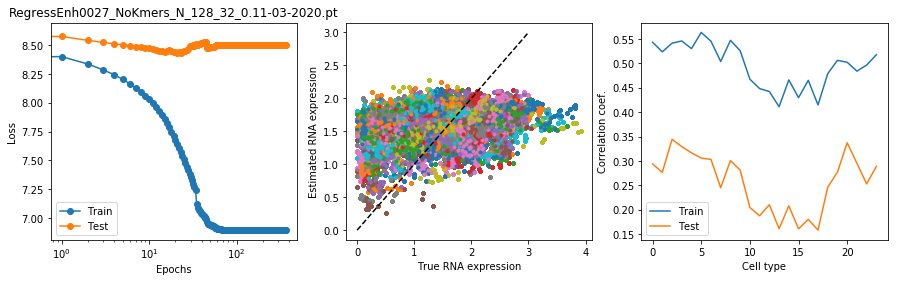

<Figure size 432x288 with 0 Axes>

Saved data: RegressEnh0027_NoKmers_N_128_32_0.11-03-2020.pt
**** Phase1 epoch 368, LR=1.2207e-08, loss_train=6.89395951, loss_test=8.50387069, time = 1.33034 s/epoch
**** Phase1 epoch 369, LR=1.2207e-08, loss_train=6.89395764, loss_test=8.50387037, time = 2.26874 s/epoch
**** Phase1 epoch 370, LR=1.2207e-08, loss_train=6.89395563, loss_test=8.50387060, time = 3.14075 s/epoch
**** Phase1 epoch 371, LR=1.2207e-08, loss_train=6.89395372, loss_test=8.50387000, time = 4.57346 s/epoch
**** Phase1 epoch 372, LR=1.2207e-08, loss_train=6.89395183, loss_test=8.50386958, time = 5.94820 s/epoch
**** Phase1 epoch 373, LR=1.2207e-08, loss_train=6.89394977, loss_test=8.50386939, time = 6.97264 s/epoch
**** Phase1 epoch 374, LR=1.2207e-08, loss_train=6.89394782, loss_test=8.50386909, time = 8.27472 s/epoch
**** Phase1 epoch 375, LR=1.2207e-08, loss_train=6.89394597, loss_test=8.50386868, time = 9.73267 s/epoch
**** Phase1 epoch 376, LR=1.2207e-08, loss_train=6.89394396, loss_test=8.50386823, time = 11

In [ ]:
num_epochs1 = 1000

fn_id = len(glob.glob('./RegressEnh*.pt'))+1 # Generate a unique ID for this run
fn_save = 'RegressEnh%0.4d_%s_N_%d_%d_%d.%s.pt' % (fn_id, ('UseKmers' if use_kmers else 'NoKmers'), N1,N2,N3,today)

t0 = time.time()
batch_size = 16
for epoch in range(num_epochs1):  # loop over the dataset multiple times
# while epoch<num_epochs1:
    new_loss_train = train_epoch(epoch);
    loss_train = np.append(loss_train, new_loss_train)
    
    new_loss_test = test_epoch(epoch);
    loss_test = np.append(loss_test,new_loss_test)
    scheduler.step(new_loss_test)

    print('**** Phase1 epoch %d, LR=%3.5g, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (
        len(loss_train), 
        optimizer.param_groups[0]['lr'],
        loss_train[-1], 
        loss_test[-1], 
        (time.time()-t0))
         )

    if (time.time()-t0)>60 or (epoch==num_epochs1-1):        
        if (epoch>0):            
            cc = np.zeros((Nc,2))
            yyhat_train, cc[:,[0]] = test_net(random.sample(train.tolist(), 500))
            yyhat_test, cc[:,[1]] = test_net(random.sample(test.tolist(), 500))

            display.clear_output(wait=True)
            display.display(plt.gcf())
            make_plot1(save=True)
#             make_plot2(save=True)  
            display.display(plt.gcf())
        t0=time.time()
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_test': loss_test,
                }, fn_save)
        print('Saved data: %s' % fn_save)


In [103]:
test.max()

6267

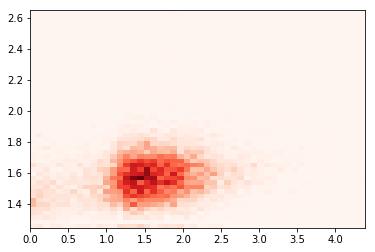

In [678]:
plt.hist2d(df['log_rna'], mdl.predict(), bins=(50,50), cmap=plt.cm.Reds);

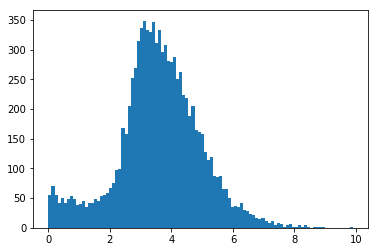

In [679]:
plt.hist(np.log(rnau.loc[genes2enhu['ensid'][best_enh],:].iloc[:,3]+1), bins=100);

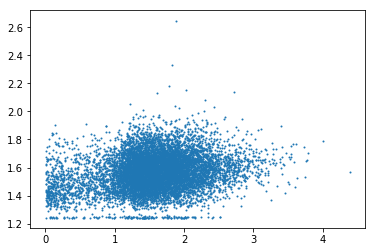

In [681]:
plt.scatter(df['log_rna'], mdl.predict(),s=1)